In [136]:
#importing some useful packages
import numpy as np
import cv2
import pickle
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [2]:
# Load the camera calibration matrix from the pickle file.
calibration_pickle = pickle.load( open( "./camera_cal/camera-calibration.p", "rb" ) )

mtx = calibration_pickle["mtx"]
dist = calibration_pickle["dist"]

In [84]:
def plot_original_and_newImage(original, new, new_title="New Image", destCmap='gray'):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(original, destCmap)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(new, destCmap)
    ax2.set_title(new_title, fontsize=30)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


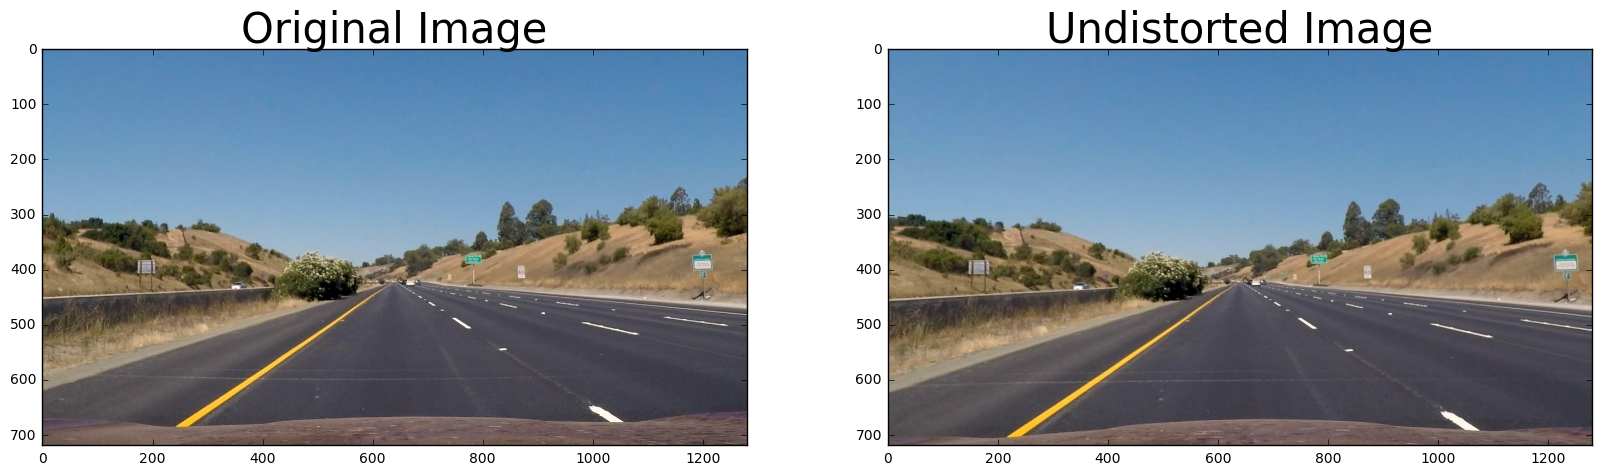

In [85]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)

dst = cv2.undistort(image, mtx, dist, None, mtx)

# Visualize undistortion
plot_original_and_newImage(image, dst, 'Undistorted Image')

In [86]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

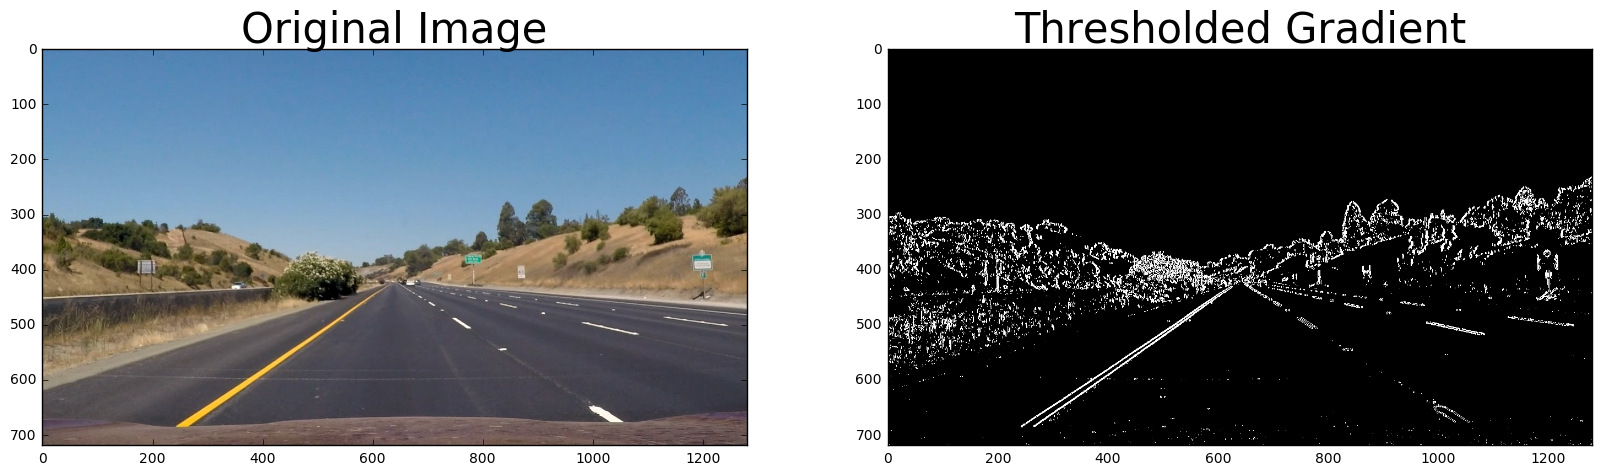

In [87]:
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh=(20,100))

# Visualize undistortion
plot_original_and_newImage(image, grad_binary, 'Thresholded Gradient')


In [88]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

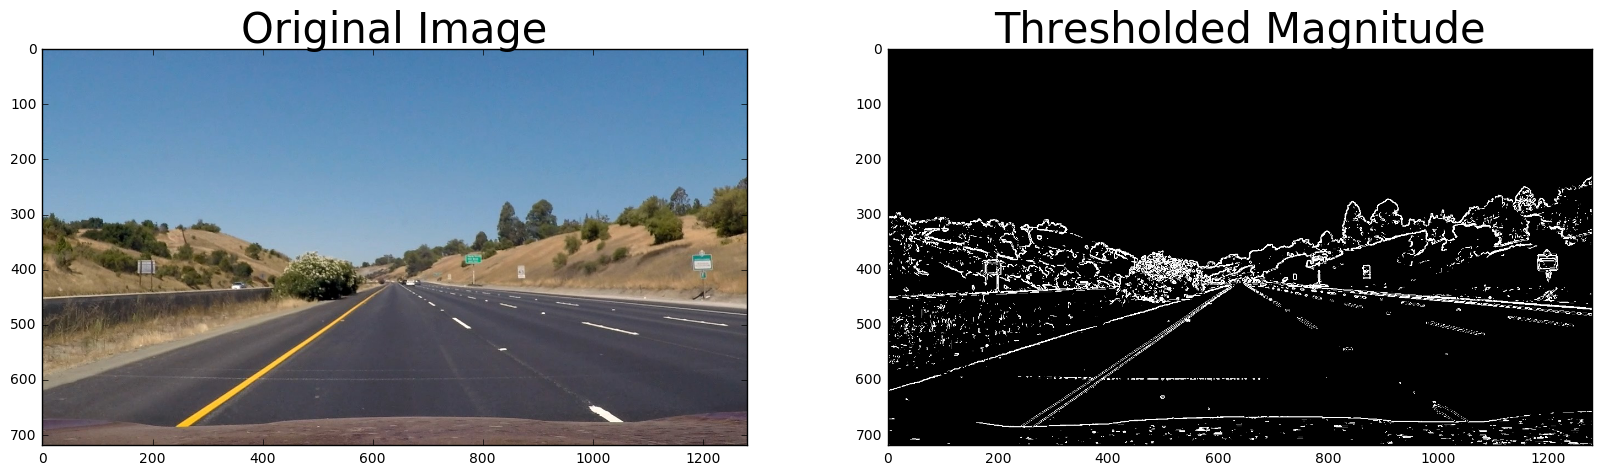

In [89]:
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))

# Visualize
plot_original_and_newImage(image, mag_binary, 'Thresholded Magnitude')

In [90]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

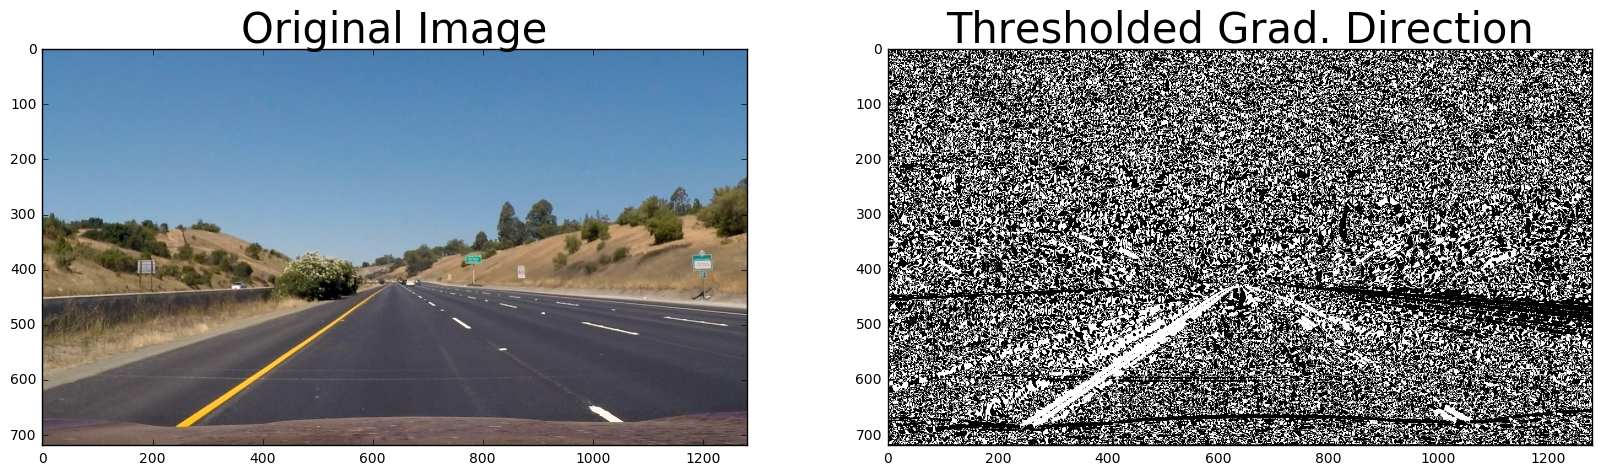

In [91]:
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

# Visualize
plot_original_and_newImage(image, dir_binary, 'Thresholded Grad. Direction')

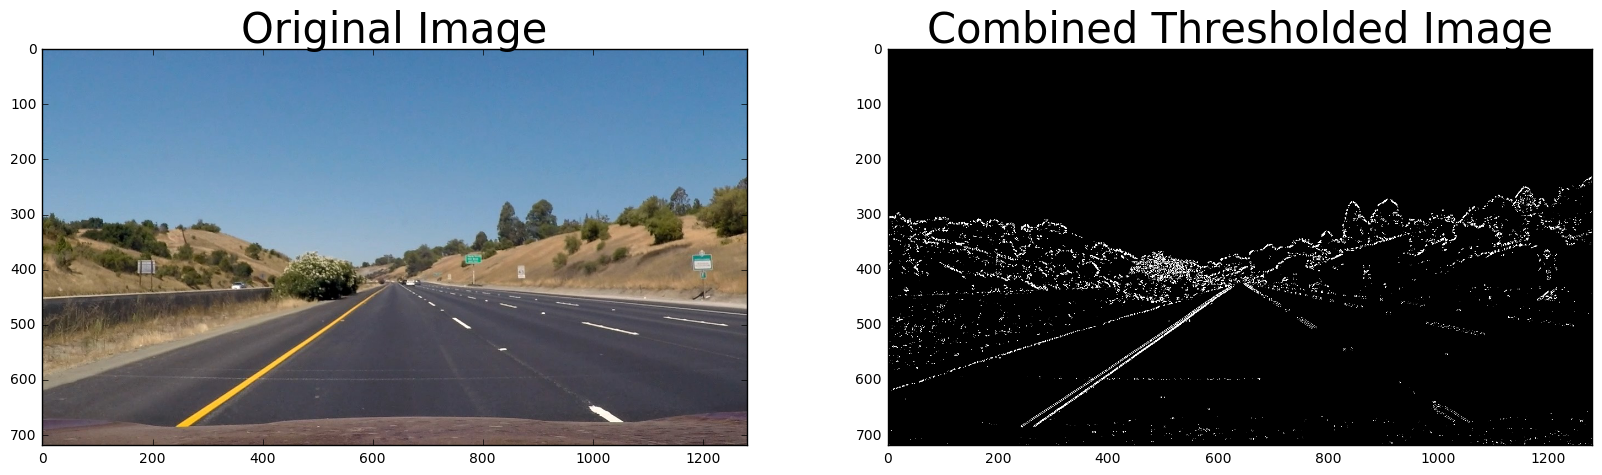

In [92]:
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7,1.3))

combined_binary = np.zeros_like(dir_binary)
combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Visualize
plot_original_and_newImage(image, combined_binary, 'Combined Thresholded Image')

In [93]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

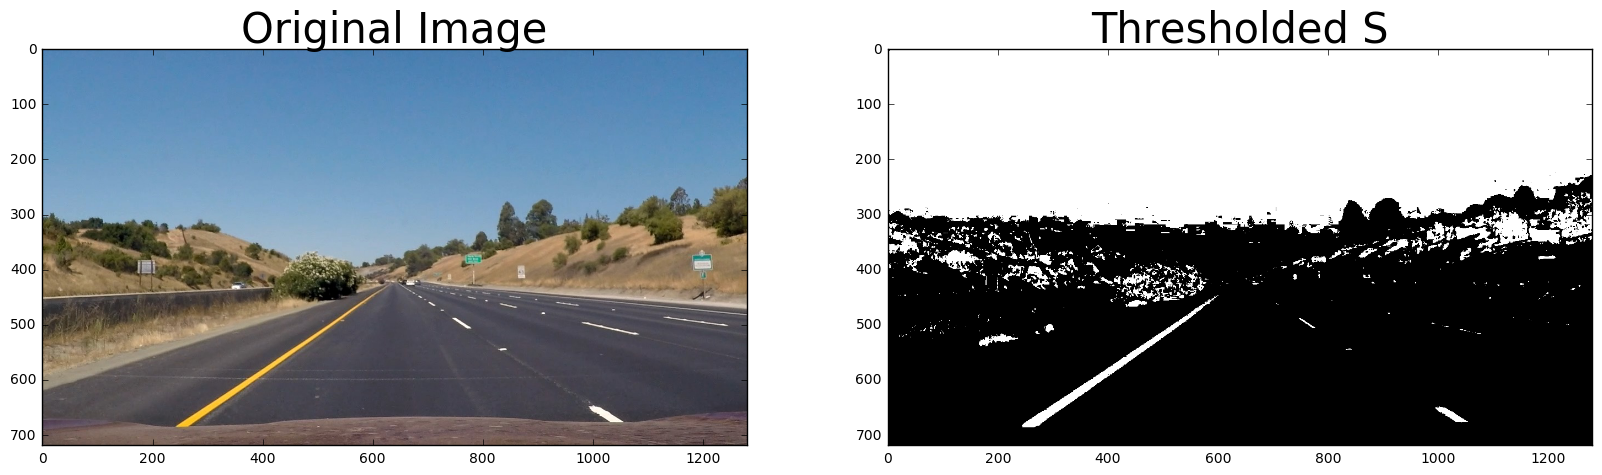

In [94]:
s_binary = hls_select(image, thresh=(90, 255))

# Visualize
plot_original_and_newImage(image, s_binary, 'Thresholded S')

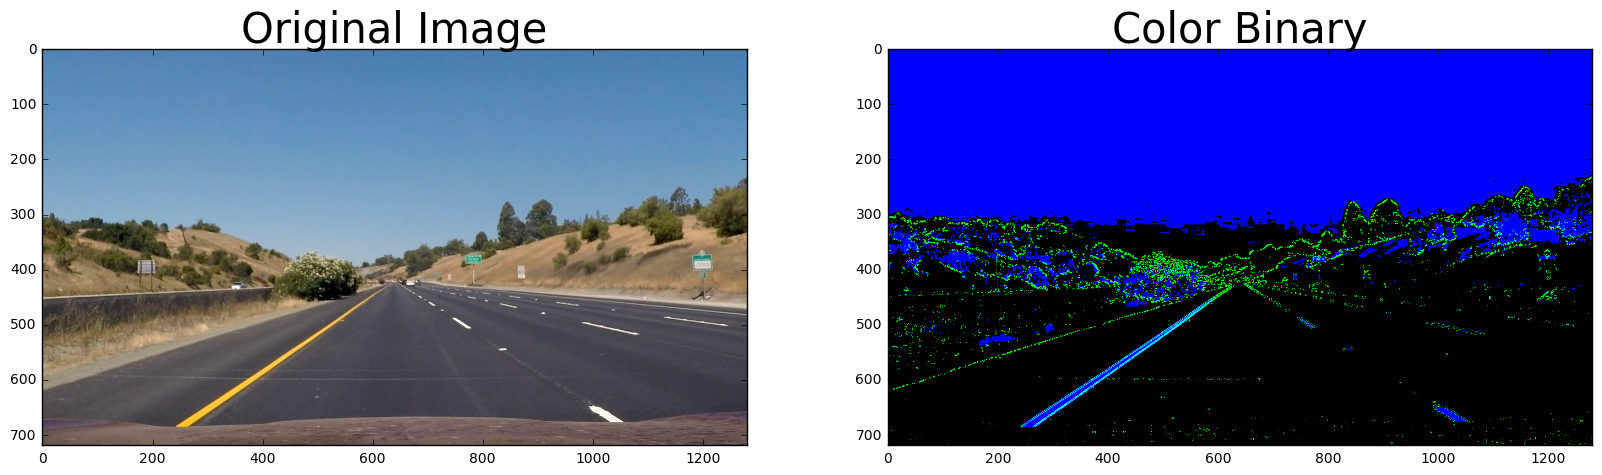

In [95]:
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(combined_binary), combined_binary, s_binary))

# Visualize
plot_original_and_newImage(image, color_binary, 'Color Binary')

In [96]:
"""
x0Vertice1 = math.ceil((120/960)*imshape[1])
x1Vertice1 = math.ceil((445/960)*imshape[1])
x2Vertice1 = math.ceil((520/960)*imshape[1])
yVertice1 = math.ceil((325/540)*imshape[0])

x0Vertice2 = math.ceil((250/960)*imshape[1])
x1Vertice2 = math.ceil((475/960)*imshape[1])
x2Vertice2 = math.ceil((490/960)*imshape[1])
yVertice2 = math.ceil((380/540)*imshape[0])
xnVertice2 = math.ceil((140/960)*imshape[1])
"""
# Image dimentions (720, 1280, 3)
def draw_poly(img):
    imshape = img.shape
    yMax = (imshape)[0]
    color = [0,255,0]
    new_image = img.copy()
    #cv2.line(new_image, (180, yMax), (580, 450), color, 10)
    #cv2.line(new_image, (580, 450), (710, 450), color, 10)
    #cv2.line(new_image, (710, 450), (1150, yMax), color, 10)
    
    cv2.line(new_image, (300, 661), (560, 476), color, 10)
    cv2.line(new_image, (560, 476), (734, 476), color, 10)
    cv2.line(new_image, (734, 476), (1010, 656), color, 10)
    return new_image

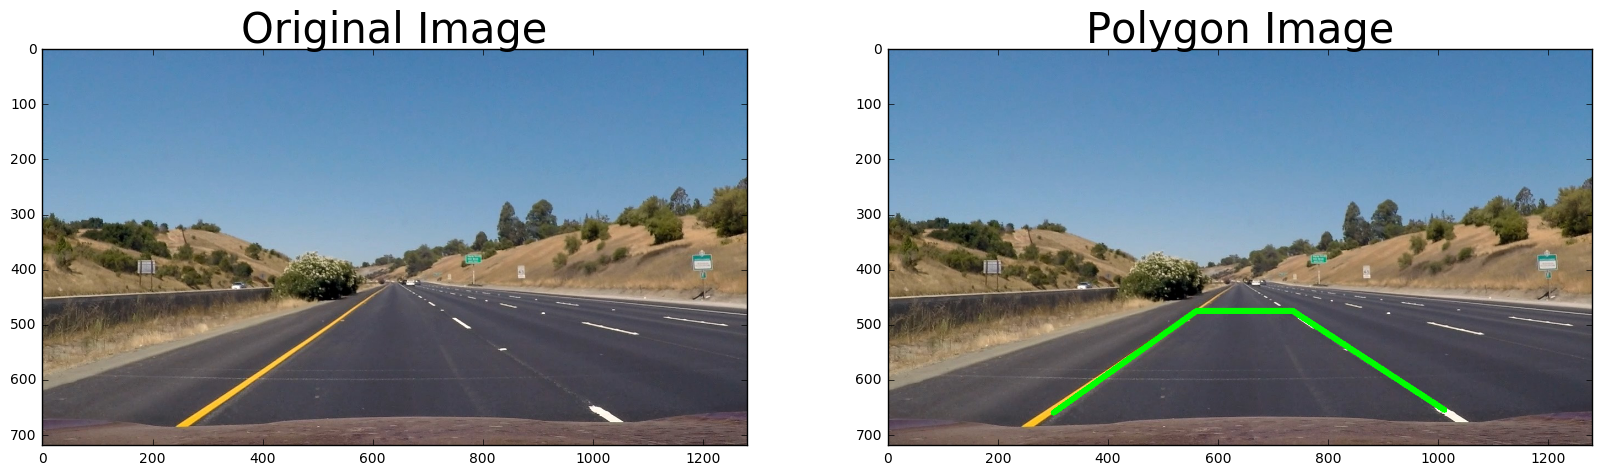

In [97]:
image_with_poly = draw_poly(image)

# Visualize
plot_original_and_newImage(image, image_with_poly, 'Polygon Image')

In [134]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

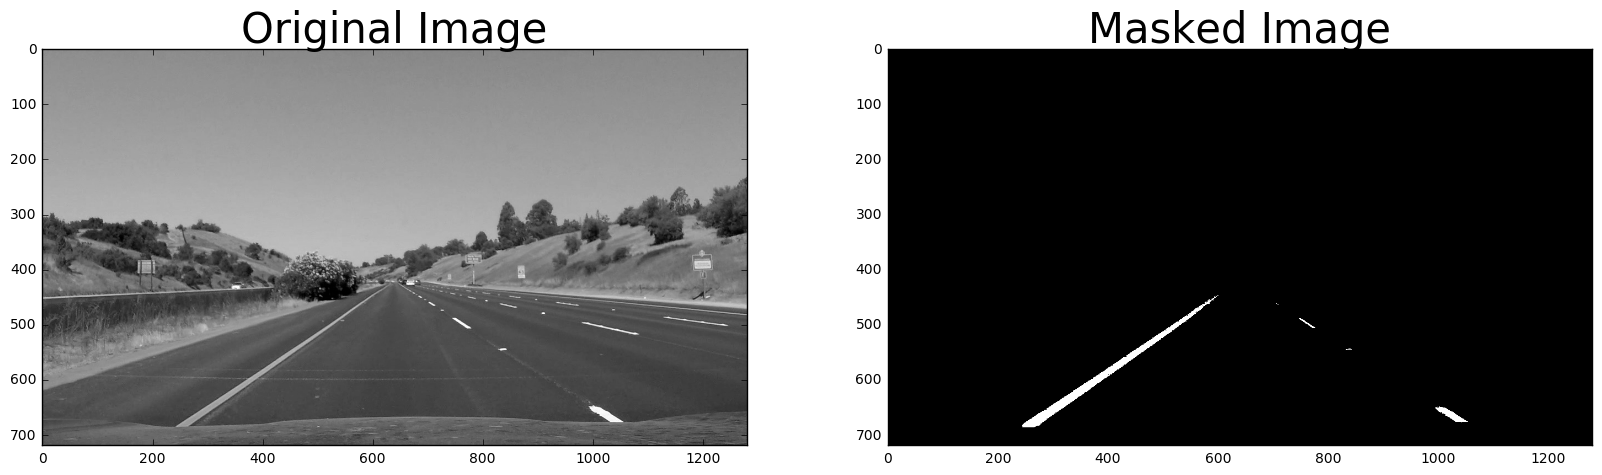

In [138]:
#vertices = np.array([[(300, 661)], [(560, 476)], [(734, 476)], [(1010, 656)]], dtype=np.int32)
#vertices1 = np.array([[(0, image.shape[0])], [(0, 0)], [(image.shape[1], 0)], [(image.shape[1], image.shape[0])]], dtype=np.int32)

#This time we are defining a four sided polygon to mask
imshape = image.shape

# Adjusting the co-ordinates according to the resolution of the image
x0Vertice1 = math.ceil((120/960)*imshape[1])
x1Vertice1 = math.ceil((445/960)*imshape[1])
x2Vertice1 = math.ceil((520/960)*imshape[1])
yVertice1 = math.ceil((325/540)*imshape[0])

vertices1 = np.array([[(x0Vertice1,imshape[0]),(x1Vertice1, yVertice1), (x2Vertice1, yVertice1), (imshape[1],imshape[0])]], dtype=np.int32)

#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
masked_image = region_of_interest(s_binary, vertices1)

# Visualize
plot_original_and_newImage(gray, masked_image, 'Masked Image')

In [139]:
def apply_perspective(img, grayscale='false'):
    
    if grayscale == 'true':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_size = (img.shape[1], img.shape[0])
    yMax = (img_size)[0]

    
    src = np.float32([[300, 661], [560, 476], [734, 476], [1010, 656]])

    offset = 180
    dst = np.float32([[offset, yMax], 
                      [offset, 0],
                      [offset+400, 0],
                      [offset+400, yMax]])

    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
            
    #delete the next two lines
    #M = None
    #warped = np.copy(img) 
    return warped, M

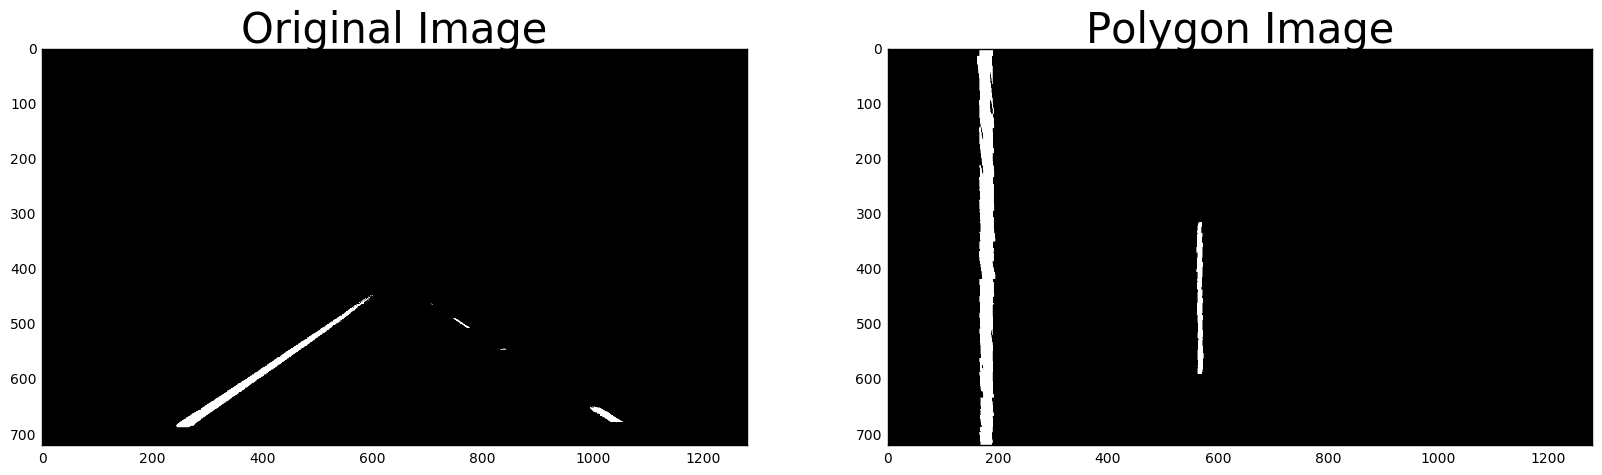

In [140]:
warped_image, M = apply_perspective(masked_image)

# Visualize
plot_original_and_newImage(masked_image, warped_image, 'Polygon Image')

/Users/saurabhsood/AnacondaPython3.5/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


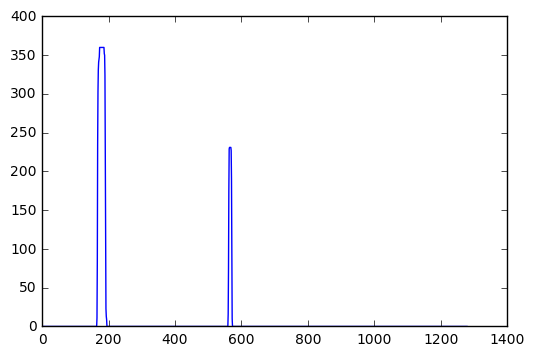

In [141]:
histogram = np.sum(warped_image[warped_image.shape[0]/2:,:], axis=0)
plt.plot(histogram)